## Implement the environment dynamics $$p(s',r | s,a)$$

Heuristic ideas:
- https://boardgamegeek.com/thread/402618/settlers-catan-strategy-tips
- https://www.meeplemountain.com/top-six/top-6-catan-strategies-for-turning-your-losing-streak-around/

Rules:
- http://reglur.spilavinir.is/catan-enska-091907.pdf

Helpful inspiration for hexagonal encoding (though it didn't end up being used): 
- https://www.redblobgames.com/grids/hexagons/


In [1]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

F:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Create basic hex board
After a lot of trial and error, I found that shearing a hexagon by 30 degrees and using a coordinate system worked pretty well

In [2]:
# edges: (x-coord % 2 == 1) OR ((x-coord % 2 == 0) AND (y-coord % 2 == 1)) (and board[coord] != 0)
# vertices: (x-coord % 2 == 0) AND (y-coord % 2 == 0)                      (and board[coord] != 0)
# faces: a little ugly: 
        #  (x-coord == y-coord) AND x-coord % 2 == 0  OR                   (and board[coord] != 0)  
        #  abs(x-coord - y-coord) ==  6 AND x-coord % 2 == 0               (and board[coord] != 0)

In [3]:
inds = np.array([                                                        [0,8], [0,9], [0,10],
                                                                  [1,7],               [1,10],
                                             [2,4], [2,5], [2,6],        [2,8],        [2,10], [2,11], [2,12],
                                      [3,3],               [3,6],               [3,9],                 [3,12],
                               [4,2],        [4,4],        [4,6], [4,7], [4,8],        [4,10],         [4,12], 
                               [5,2],               [5,5],               [5,8],                [5,11], 
                               [6,2], [6,3], [6,4],        [6,6],        [6,8], [6,9], [6,10], 
                        [7,1],               [7,4],               [7,7],               [7,10],
                 [8,0],        [8,2],        [8,4], [8,5], [8,6],        [8,8],        [8,10], 
                 [9,0],               [9,3],               [9,6],               [9,9], 
                 [10,0],[10,1],[10,2],       [10,4],       [10,6],[10,7],[10,8],
                               [11,2],              [11,5],
                               [12,2],[12,3],[12,4],
                ])
inds = inds + 2
board = np.zeros((17,17))
board[tuple([*inds.T])] = 1

for x in np.arange(17):
    for y in np.arange(17):
        if board[x,y] != 0:
            if (x % 2 == 1) or ((x % 2 == 0) and (y % 2 == 1)):
                board[x,y] = 0.3
            elif ((x == y) and (x % 2 == 0)) or ((abs(x - y) == 6) and x % 2 == 0):
                board[x,y] = 1
            elif (x % 2 == 0) and (y % 2 == 0):
                board[x,y] = 0.6

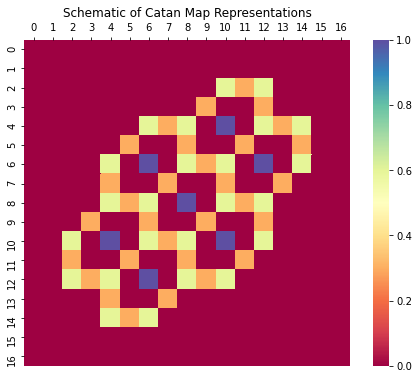

In [4]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(board, square=True, cmap='Spectral')
ax.xaxis.tick_top() # x axis on top
plt.title('Schematic of Catan Map Representations');

Undoing the shear transformation, we see that this is what we expect from the board:

<!-- Generator: Adobe Illustrator 24.2.3, SVG Export Plug-In  -->
<svg version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
	 width="387.08px" height="259.93px" viewBox="0 0 387.08 259.93"
	 style="overflow:visible;enable-background:new 0 0 387.08 259.93;" xml:space="preserve">
<defs>
</defs>
<image style="overflow:visible;" width="481" height="323" xlink:href="data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEAWQBZAAD/7AARRHVja3kAAQAEAAAAHgAA/+4AIUFkb2JlAGTAAAAAAQMA
EAMCAwYAABBeAAAdrQAAQ3//2wCEABALCwsMCxAMDBAXDw0PFxsUEBAUGx8XFxcXFx8eFxoaGhoX
Hh4jJSclIx4vLzMzLy9AQEBAQEBAQEBAQEBAQEABEQ8PERMRFRISFRQRFBEUGhQWFhQaJhoaHBoa
JjAjHh4eHiMwKy4nJycuKzU1MDA1NUBAP0BAQEBAQEBAQEBAQP/CABEIAUMB4AMBIgACEQEDEQH/
xADiAAEAAgMBAQEAAAAAAAAAAAAABQYDBAcCAQgBAQADAQEAAAAAAAAAAAAAAAACBAUDARAAAQQB
AgUEAgICAwEBAAAAAwECBAUAEgYQIBETFDAkFRZANSEHMTNQMiU2IhEAAgEBBAMKCgYHBgYDAQAA
AQIDEQAhMQQQQRIgUWFxgdEiMhMzMJFCkpMUNKQFRUChcrLSI7HB4VJighVQ8bPTJKXwosLio+Nj
c2Q1EgABAgMEBgkEAgIDAAAAAAABAAIRITFBcRIyECAwUWGxgZGh0SKSAxNEQOFCclKDYDPwwTT/
2gAMAwEAAhEDEQAAANOJlImW57+eXs/X3wPX3wPTyPfzyPbwPX3wPX3wPfzyPfzyPfzyPX3wPX3w
PfzyNXVkYiOZmlYLJ7TtcbJfbsKu84aM9jo3Mdrx3Zq7QAAAAAAAABzGJlome+CYAAAAAAAAAAAA
DU2/iEIz4IYUtP0q12quGtXiskaKti59N/P/AGIngAAAAAAAAcxiZaJnvgmAAAAA9+NzzzG6b6p5
3LnRNeNmifb7Je8+Ya/V6P19gBZuAAAYYmcjvKGpt6jzLvWKPnLubQfFjrlPQS0SjPv3qi3oAAAA
AAAA5jEy0TPfBMAAAAAkp3hDFbazoVaFzjqn49nbduievOnQ9fQ2OFHnmKz1jU1w6SAAefQhfMjH
Rw8l7oE1KlaqL0OJ9r0gc7+ftnDLYdUAAAAAAABzGJlome+CYABI7/PnX1gweIZM5HsJd4be4cZS
Mwq6rNzFq9MDPgSlbbz240OchS77pceNCTK/bhk77Qr6fgJyCU0TLYvK8Q+/I4t9leddIUaLCdN5
t5Yxj3t16xcT7SewAAAAAAcxiZaJnvgmABt9J5XbqtG06W75o58Z78/IaMp91dqebRIPpvNtDV87
8dsXo7WrtfO+fHber8o7fVPdRt2Zh6etJx3Gz9kYvbebVIu+v34cwZcWluB60NKaiI5Xi5U3JGh1
esWHZ51uQpGO623Ruc5TvaPkAAAAAADmMTLRM98EwEzDIedC8ae/kVaNrW2palkO0vd5octW52yA
n/lDhz5tauvbD1M2nntyocd6k3iN5Qp41LL15F52ahb8mrB1noNKtddMXOrW2SMG2NeGDYuhcb6Z
y4/eZdo594rA7dLR1j8/9bLKAAAAADmMTLRM98EwLLI1notLMhK/fabH3Tj9b1eu7PzYXcqNZ8FT
XvEvzzpOZnRsLbtLn5Xs8l6WdHNNfZUKH5kKtc1dr7qyN+pr6slq+te7UnapXOix8pkzcjlCxV3U
2QnPHETeh5R0t/QQy+0YqneKUOL4Oh88tzScYm73l550MAAAAA5jEy0TPfBMBbal758+nYo7PlUK
JgtVV1NHPm0lnhue9Ca4y17BIeM7n8+UvWs+XD5UCxe5bl9z4VZnnV6ivJVLPgadnd+abpX3smW1
5vWN3vVIhwt1ILlgOnV8+iG8SkXHE99g45YOHDqPJOvwldyV683nvtPE7IdcfPoAAABzGJlome+C
YAEva+e36jW907oWDjW5ouizdpa+5/eMfvfKbX8sFQ3sd3rqt7za5ae9ouFzoP2OsOTnUGL6ZD2+
9LXTZnOhXKS88q6MgPKxovvy/wBwAEXKY/OEO+/I4nULPxjs1P3nFQ7jxfs1h286ra+H9qMwAAAO
YxO7pS3A97AAN/Zy8Od5+1vzTyZvVjdSNufkqdvo2Om2nG4c19ZMOrryTTyW8jxg2d6roR3SqZKU
eVm1IT5xqyXqARu3H7WpyOfWqt0rnl3QwC1aAAA0dGbiY5eK+0LJCj3enzUnTnwdPQN2C+0L3676
ipUAAA43iyxXtqVEtgAZfEraKHcKHDZo93io+VZ9aXf59+Ht326ZdMqrD1TodPsdIxkXO2OZi/sI
3xo7WVWqMfcqdpWPj787zXOmbvCF1iZdm1ueJOM17YS9AAYM5GDbWrDCn+rcK6XWS3IO48/j7TBb
5z/YOAdRLeAADjcHOQZJbULMS1/Q9tr5Q9rlw6bFyGTOxuULDXtTd3csfIXcrzHyWtHprXak56V7
qHjzlzMSL+bWrz0t7PGSUqcfzrq1Pt2Kxt6n3QvSPn79uYka2tWnuXOycv6VnZuDnHVKj7KrC9qA
AAY4ib0vKWhuaaGV2r5RL7m2uQ6XRedX67c03SPeNjm3SQADmtJ7xxQ0t3S+uk2xZZ7oPbFZ+b3f
Pq7dBvsNH2rZMbT75vmJ7GybMLb8znGxVnpcvNzDFrfaUlat9i6Rh0tzMp0TBbKnqXffvC7xyztd
kOKdySLM4VjxraGl2Dr1AAAfPoiMUrFRxfXUuVy3Dn1HmXSI+nZ5a9edKl67JxmaOzPPoAVK2/Dg
CxV0zS0HI+6G2JaSSjUfOko+eysij619jutqqZ7Jv+qZKWXU8r17Tg/FrTzMufRz9DxIR/K1v3nm
91z4ylWu+OtToS2/J3619t+1KnWcNk5p73m4AuXAn6AAAAjpHx5xhnrzHEvNm5R0vPvVip9V5r34
6gs1um3PhXbDZABFcX77zYpHryezXqOkZbge9dnpPLdnhV6dp0Fw43X3REbHTPtNsHGhE1DolFt3
taQjvV9Ia2FPj4z2fazbUzmqtf40L/q0rxK1eZHmvpHpdXrvzpDTFu+AAAAABpx83ExzMVkrf2FP
qcJm387W5ilonRyFypvqUe/IOcAGtsjhuj1blIlonL7Yl3z7LaAAA+3ejydfnb46cZ1LmS26ejdr
yw7XsYa4RGStykqXKacusUL3YAAAAAAAABhzHkG3NOGFIXjm9orW5eh9Br8etbFvLmuy8A6QXgAD
kfXIs4myYyQ3IWXlrex7cAAAvE/zDoNDJ3I3Z1q0fm3GffLM5q+fs6HN8doq+ntBPoAAAAAAAAAB
5h5rU8px2TGjlXrJWLLU26bq2qq2Mpmwp8P0AAADn/P+98VI7a1Sc4wZ57oJAAAAAAAAAAAAAAAA
AAPn0ROGXiI4y01bZh5bqzP4oalUevPXD/QAAAFZsw/P61VUyy0Jv+390S0wAAAAAAAAAAAAAAAA
AAEfIefOUK9+I4cvJ1ee81dWJscF7X70FEAACDoYPY9kB7eAAAAAAAAAAAAAAAAAAAA1Nc8pt0e7
GqLH/9oACAECAAEFAPXVMY5GucNrmqiov5kcnVJA/wAN3Xp5bsWa7EmquCka3cipiKqKhEc17dLv
wSSWDcqNMRYZFxIZUzqrXBIhGci4x3THr1T1nFG1e+LO+LJKjI1gjMcxr3NVrm5LDkcijf5As74s
a9ruCpwVcRfWlD6oqdeCLkYutoX9FezU1zeuFGrHKmNXAk0PRevBUxU6pq6Kn8+oRiPa5qscAvcZ
koWtgiKN7XI5MmC6LGLofwOLtvhl6pxKnTBP9Q7iscFzXvEwbHdtio5qtWQFGPQhGokguKYioMYX
tC1itKNEQ4kIxqq1zHo9uKmKnVH9WOG9Ht9Io0exVc1QFQjGmc1JBSKx0lz0SKJyeELJAO2kY2l7
XK1e+7DyCjeFGGcMSDTgqYcetoX6HenLD/ICKJ3mjzzBriA7rooSNRQORHNRzSCVjhy0axJo8MUZ
Wsila7iqcDD0uA/q3mTkccKogXOxYxc7BWoIuh7XY0zVQ7xsU7xERY5VzxjY5rmLFLqbyKmPbqaj
lY5qoqcqLx65LEnWKRWP6LnTJAu2+IX+OqYRrXtcxzVjEV7OmSBdxjHqxzHI9vLIZkcvReZF4GHr
Y1Va5j0e0T9TTs6oYetipip0xFyKXorH6XfwqParXSR6XRS9F5FTFRFQjFG8JNbPQlj0rFNpeiqm
a34dSjfGcx69kWOjjVq6muAXuMR7kSR3HsQz+rGCcnKqYcWtgC6H8yLwe1HNePQ7yipiSy443cVs
UbVaIbkKPSssKLgyOHnmFxJZMCIRcGNBpyrwki0uil1N5k4HB3MWG5c8J+Eao3RDakGTRjytc10t
qKMHcRYTsSG9MHHex3OqYRiPamob2uRzeVF5ZItbGK5rklB6eSHDtYV0cZhv9SQLrkd+leZF5ZAl
a9WOxGuTER6KN+tvpqnB49LmO6p+WqY5vVG/wvMi/irwVMT8/wD/2gAIAQMAAQUAEIaj7Q87Q87Q
87Q87Q87Q87Q87Q87Q87Q87Q87Q87Q87Q8mg7b81+qH/AFesUaEY9iscZOmBL1X0w/6uZyuRvyLs
ZJ1tNMeNY8zuv5J4OqORHI5rhvG9Ht9IP+rmcRGqaN3SAimYpIzntSMVqjcrm8VRFSQFREkD1NAT
Q70g/wCri44mq0wnY4o2oQ4XIjXorjiarCsfh0REHJG1e4zFkBRWFY/hKB3R4YWlwH6m+iH/AFcZ
wdTRE0PVEchGKx0M/cZNBrYAyiIul7TiURI5NTZI+qRzKIiKipk4Glz2o5rerXIvVPQD/q4ORFRU
VFY7UmFb1RrtKovVMK3Bu0rwe3SonfxhBoRhGOY4jcGvT0Q/6uEt5xPiH1PKNVZ5R0UREIyWhBPj
SX9XuIrVknwKjKOY4wnQ5TlccbnjQ5WuERCMycDU3NPoh/1cDCaVnisRWO1NJDE9zAoFpFQrUgBz
stw0NirHa0SlG0jUgCRXve1fGEV4QNEmKnXJIe0T0Q/6uMlUYg5rGu7zcfOG1wnNNjnqFjZ4lVUR
UKZBvDLY9r5LWNdNE/Gici8ZIe6NU6YmLzxiI8PF7huRYheoBmRsiM9yAQwiKiOaSGVHR3PaOYNp
WjjyGOUTlQkYjXQ3P0ck4Gl2dOvPDP2ycFVEwqJ1E5UXUmfwuEbpUL0zqmO0qiouMf1b1TCN1Iju
itVFTi9iPaQajexce3+OaEfWzJIe6NrnMeIiEZMB2yQTaXSAoUf8tcN6PbIHpdBP0U4UKP8A/THA
KhRzQ6HwT6Xck4GpmM6Oa9uleUJVG9rkc3DAZ1DpYrmNeiRwor1c1WDE9WiG3HiY5O0xqsdqRwRO
VRNa1V1Y0AV5pQO0QT9Lij1N5oB+i4qdUIYw3glOe08grEbNe5yDbhZUgb4sjutma2tFMe13edhJ
h2OikaZGtRqcsgKFGqKixn62yRaV5UVUWOZCjyVF72DhEY5QKqPhOa6LqayTG7yBhlE9xGriQHOw
cd7WmhqRAwyjfzzwdFG9WPVrSjexWO5Yp+0TkK3q1JI0Vpxua+SJmKYRHDa9q+k9qOaUajfBN0Wa
DU3mgn1s5JkdWkjK9riC1tRpGuCTuD9OaDWxFVFjlQo5Qe0TlERRvY9Ht/Elg7RIp+0SSFCjVOnN
BPpX8Q4UKNyK1YJ9bJwNLuVv+fxS/wDcP/cv/T//2gAIAQEAAQUA3QUzb7vHzvHzvHzvHzvHzvHz
vHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHzvHybInCX5C
fnyE/Kma87NLstvMC35CfnyE/PkJ+f19uJ8+L+Jun9/+aRiEYRjhvyOd8cwSNMIg2kZLjPin4Vlg
assKywDZ1/4e6f3/AOdOj628KOagydMt4Hkg4/15uBIcz8PdP7/85U6pKB2icKqakyN0y6geMfgi
qi7Q3El7W/hbp/f+sIJjO+OsM+OsM8KYmeFMxIM12fHWGfHWGOarV9CSFDC4Vk10OU3S9s2G2XHK
N4icNs3haO0Y9hGfg7p/f+tVWJKyaIrDCyWLS7BEUb0VFTN2VKRJXozwaX8NuT+8PTm5K5Vbx/ri
/aWP+Dun9/6+z7ZdWPYj2vYrHZEL1TJ8MU6JKjGiSPQexr2FG4T8jnJHNBksmxSgYYVlAJXy+EKb
JgSqi0jW1f8Agbp/f+rSBr5Jvr1Vg6KuESxvr6DK+2XeE3NbkX7Da43cdsx0C3fNjeUfN0QlOz0Z
wNbOG2rJIsrTm4atJsLjsHcbaud+Bun9/wCqMjhEr5bZkTL2vSZE5KCwWLKxzUc22geDL9GUBQkz
/GbesvkYOnNz1ToUzjsrcC3VX6+6f3/PVUkm1T6Va4uy7VE+rWGfV7DBbQsip9KtcrKG0qXfaK/P
tFfkxQTJniEzxCZ/jhtuUs+L4RctqMs+J9WsEz6vYYLaFkXPpVrj9mWrWKitXjIChhqitXKexWtn
sVhGWNeGwiSI5opuG27haW3CYZw+tun9/wA9VYOrpwSsOLJYtLsCTtvRUVM3TTpAlYN6jc1yObko
Wlcq7AtdMAcUgWSxaXYEijeio5M3ZUeLJ5J4Oi8NnXKlbpzeNN3Q8f64v3GF626f3/obQt9bMIxC
Nc1WOyIXqmWMANjEkRzRjZFL0XHNRzXsVjs2hb6H49iPa9isdkMvXhPhCnxJcYkSTxe1HtMNREyP
IPFPWTwWcJ4mEZe1S1NjwiSjQ5NHait6v1d0/v8Am29Y+OfCiGYc+GSFJ4gM8BoclsuLm5a9FZyb
dsFBIwjGkZZQlgy+IivCSvmNmxM3JXqUXJNB3B8NnXCwp+nNzUy2tdx2JuBtTZerun9/zIqotNP8
6Jl/XpKi8m3rBY0rHNa9tlBfAl8UXplNYJNiZeV6zYnJQ2CQ5WOajktYLoMvkmA7JOG07htpW6c3
rReFK4IqouyNwJb1nqbp/f8ALR0FPaRPpVVgtshr2v3LZDf9osMRByn+IPHRG6f8cNuSgWULwhZZ
0MWwD9Wr8+r1+R9o1RU+lVWA2yCvQu5LMJPtFhiduWXxB46IxG/44balDsInhCy6pATIaorV4nEh
hKiouUlo+qs45hSQWFfHsYc6EeBL4beujUlnFlR5kf090/v+WktH1k0b2kZm7qfslwb1G9FRUyUL
S7KmyJWTRkGUeSxaXYx6sc1yPbm8KlGuxj1Y5rkcmShdFysnvrpsc45Ac3bUrHk8lgD+eGwLteun
N+0qyYnH+uL9yE9PdP7/AJtqXbe15QMlLDlx5sV8STkc6MTyQ484HtDSz5Avr1rlLLPTwftlJj90
0b2LuGq6/YarK/cVaQvlAw5IsgNhDdBl5HOjE8kOOkAc0FNOkj+vWuUkmZURvtlJk3cG3psZeiLx
c1r2mE4RMCYgDUdsG5riCGUe5aUlPZ8AlIAu3roN3Welun9/zAM8BoUpkyNm4a9ZMfk25YIA+FEM
w7CE+DK4tc5jqiwSdEy/rvKjcm37HxpGEGwrLGESFK5pgO6Phs/cC1Fh0zdVC25rSMeN/DZF+6pt
EVFT0d0/v+fb9j40jFRFS6r1hS+LXK1aee2dEy9rvMi8lRPWFLa5rm5fVyxJXFFVFpbDzYmXteku
LzzQdonDY198lX9M3/QthyuOw9wNsq70d0/v+dFVF2/NjWULxgZMq4UsS0VWi/CVWRqKkIn1ukyR
RRwxlu7VF+btcCgzZ44cJGYrOG05w5YPGBkushywrR1aL8JVZGoaUifW6TCUEIQSXFuN/wA3a497
nv5jiQonNVrsorY1PZAMOQCxgBsIVlXyKybwo7YlPZxJQZkb0N0/v/QpbN9ZNY9r2ZLF0XBvUb2u
Rzc3fUoEuDeo3tVHJkoWl2Q5RIcqFMDOjZLF/ODerHscj25vCpcj/Rng4/13fsbw3/t/zIvH+u9x
Ix3oblP03TzxtuklA+qyMizDUFb93i47e0Ryfao+fao+VW6I5z+a3JBgSQTIhIcnASO23zG4+SN7
Ym3iS4/1WRlUOXRR/u8XHb2iORd1R+v2qPlZumOY/mtyQYEkE2K+JJ9BURySAqEuR5BYx9u3Yrqt
Xo5N30Xw9pwAYkc227lt1Vc+9FVN0xzIYfNt6y7JcOEcgU2KSJJ4se4b6uc2dEzcNd5Mbk27Y9g+
KiKl1X+FL4tVWrTz0mxM3BXLKj+jLB3h8Nn3rqmzR6OTcdOy6rCDeInDZ18+mtEVFTm3r/8AURD9
onKkWUqNizGrXzO7D8iPl/HjSo2l2aXYrVThTWCwpaIrk0Oy4qTQ5XjyM8eRniSsSLLRa2f3ovkR
8tRRp0NWPRdLsVFThUz1gy2orm6HZe1qwpXozgdsnDY978hA65v6jURuP9f37Z0Dm3r/APUZBPrZ
ybXtvOh5uCqSzgqiouRy9xmEYhGKioubStvKi4UaFYqKi5FLrbl7WNsoD2OG/IpeqYRiPY5FaubR
tkODLeuZYwTCIAvoGEhRvY5jsqbI1ZPiTATY02KGdFt6w9VP4VFnIqZ8GaCfE5d6/wD1GCIo3sej
2caywLXS4xxyQZu2pWNJwRFG9FRUyULhBmGgyosoMyPkwXAb1G9rkc3N31KjJjXK1zHo9uShdeEK
WWFKiSRy42bwqkavozwdU4bFvPHPqze9Qk2Bx/rzcTYpuX+xqFY8rhAP0Xk2xckAvlmyWvmR5UYs
Q+MkEY3yi46SRza+oqJ0b63WZIdKpa77fc47dtw5v2Szz7JZ5R7klGP5ZslOWXHmxXxJODM8aeUX
FklVKypqp0T63WYZJNNX/b7nDbptTh9FURUkBUJMG9437fuG21cqoqbopn1lhwY9w37VvmXlXyTo
YZ0O3q5FRYYiqixjd4XFj3MfWzEmw83FXoePyUVgsOXip1y4r/Al8WuVrque2dFzcFesqNyUth4U
tFRUy5r1gy/TlgQov8cNuW/xNi17XNvawVpXlEQJOG1LxaW2G9pGcm/NuJZQeEUyhLyUU9IctIhV
zwy5P2rNZJ+s2OJtiyVfptvn023xxy0sL7NXZa29bPieKRc8QuEC8fCnsXQZLYpHIsIjksNqzGSf
rNjn1mxxNnWzk+m2+d2VTQ/s1dlpbVc+N6k4Gh/DZ926SDVm8qZWk4/13fOmRORURyb02+tPacIJ
0czk2tcLOjYcSEYqKi5GL3GZZ14bGGcBY5cil6phRoRioqLm0rbyY+GGhGKiouRC8J8IU6JJjmin
9Ug0IwjFG/IE00CVEmBmR5AhyQWkB9dN4VViWrsa6eCxhcm46QV3VlEQJcGRw3se0jONfONXy40g
UoGSxdFwRFG9rkcmbwqdY8Y5WOY9HtyULhBmFgy4cocyLksXRca5WuERCMzeFSjx+tPBqbw2lbKE
2rNz1nnQ+P8AXl+2FL5f7FoFBI4QZGh3ICzsI4/m7fFubZyfKWOfKWObdupLyd4uPe8jLOC6BLxp
HtTvFzukyuj1k6L8XXZbClxYfzdvi3Ns5PlLHPlLHG3Fq3Pm7fH29oRnrKnVJIeyXGucx1NZtsIW
rNw1qQZnAZHiJtO9ZdVXJYQQWMO5qZFPYYi9Fim7w/QY943105k6Ll1XLOiclHYpClY5qObbQHQZ
X4skKGGqKi5S2a10tpEe2xhjnxSieEnDal+6is2uRzeTftA2yreEY3ZKioqehQz/ABJ3g54OWm0x
vk/U8Taadfo3XPouWEiVQh+2ZZXYrAH408HR3DbVkpRas3NXq9OP9c7gdIBy722+6os+EA+pvo7S
tVlxMexHsc1WuyGXqmWUFlhCkxyxj/jkG0jCDcN+RzvjniSxy45GsKyxhPhSuEKWeDL5dxUobqsk
RzRjYx7mOE9CD9CvmEgTQ3VUUXy1Vkuwq3Z8jX42ygNcy4q3N+Wqs3YyvlN/InR9beFDYdg2rLqD
5kb/AB6P9i7e4wT6H/8AE/5yUHslxFVFqZ6So2rLmEkaR6EqMGXHv6h9NaYiqixDIUX/ABMkPeEq
Ki5AluiSEIjklhbJjkG4b/Q3xt91vWqnThGOoSIvVP8AiZ4NLuFRM6s15bxtXpb7258XO4QDqqf8
S9rXtMNREwZHCeCQ0w3KjmyQKAvobv7Pw3/mZ/5mB+N7vsM9hnsM9hnsM9hnsM9hnsM9hnsM9hns
M9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hnsM9hkz4
7V/5mf8AmZC+P7fscnfH9P/aAAgBAgIGPwD6AEiItUAAI0KgbPrcBsosY6fozARNiyjrWQdayjrW
EjDu1gRYr6oj6LC4O6kfbkYRIdLqVW9aq3rVoLSg4XG/6aBcAVnCzheFwxNpx4IODHRCDg0zUxBe
4253ep5XSPes4WcLwmMPo8Yq2t2pA5m8lhNDzUOpFpHAotPRdoggbKG5RH0JabUQZFpQP5CTtGIZ
mckHDpuQImDo9wWyd3qByuke/SR+Jm1e2ajLdqYh0rCejaSccLqKHqgOJoSohogZFUCIKiB4XTCg
1xA3LOVAuiDYUHBjeN6hhEWrE0UqoWiYQIkWlBwt0wKhuoo9ezLbbL1uLSgbaG9QlLesTQ2LeFiw
vDcMbK9CBBcQeKq/rQc2JbQxWE5Xc1EKjURBsDMSsTsfhdXwyBRDSZ79SIq1Toa7T3G25lGrTULK
/sVHJx9MgCNHVCwOc3e1RiEWmhRabEA8OJEohUd2ICBBBkSg5rmSv1oijlhNW8tmWudwImiWDG2N
VlRJaYCaDuu5BzTxBQiYFYsUnc0MLhiEr1lWQ9ig8YSsBM20u1iFxCBFuyD2/lIw3rCY4X89E1LK
6Y7l7bjSbe5VCLSRNEEUU8zZHv0SzNmO5BwqEHCh1sY6VgNtL9jC0TCBEi0oOFqgahYhZW5EW1F6
gdOA0NL1HrW8FELEKO5rAaOpfrQNqh0goG2h2OMUdW9YTlfzUjBZioB7sJm2aLXgOdUE2rI3qRAa
Gk2gKBkWlA2iRUASotc7E2Yn2IYiXgHK6iDmtbOdNeWZsx3KdDI7EtNCi02ICXUvx6kB6mUGyqDm
4pTE0CIqVCvcApmRLDXevx6l+PUiXCDoxlRYWxhx2GIUdzWA1bS7YggwI5LM1ZmrC5YDVtLkYzBR
ECi1zHbiFia4ARoahZmrM1BwcPtsS02ri0oOFuziMzZjuQcKhCLoHdArN2FA+kcTjUU5qbfC6sxt
cYqKrCaHntMTRJ27eqHqWU9SBAMp0QMIG3bclxt/wS1Wq1Wq1Wq1Wq1Wq1Wq1Wq1Wq1Wq1Wq3U//
2gAIAQMCBj8AYSxuRtg3LIzyhZGeULIzyhZGeULIzyhZGeULIzyhZGeULIzyhZGeULIzyhZGeULI
zyhZGeULG0eF/Ydv6f6N5bcsdb2FFrqtMFiHSsJ6Np6f6N5a5LREwkF/rHWg4CqHgBBtisDmhsaa
o9VtWyddvRBoVC1pkg7rv2fp/o3lrwIKLvSIEZkOlNEEsLTxtRbLheogtBad6BNbYb9SBtRbYZtu
URVvJQOV2z9P9G8tQtc8AixeFwMFEuACk9sUCAVBzg07ijgcHQrBYzIWrMIFVCgXtBRwODoVholm
bNvdoiKOUDVuy9P9G8tT3GibM132QNlCoVBCLSsLj42dosK9xo8TK8W/ZB1lHDgv5NcOwosNLDvC
wmreSxiorcg78TJ1yBFDo9xo8L6/t91DqUdyiNj6f6N5aYFQ3LjboiKhRURoxDpXA6eFiwmymgsd
RyLHVaoqGx9P9G8tMnuwOm3uWD1TixZSd+5H2zgdYRyU3ukaFB4t5qLXHA+Y4bwsDnGdEQ1xBsUC
83FB4AnUbigWvdgdTgdyweoY4spO/ciGmDhMdyzGIKDxbz0e62rM1322fp/o3lpLXXi9VcCOK5ov
OIE1wo+2SYzg6awvEoxlXoQIc/eJjuVSsfinVEAmDt6LHUKiC+XEdyhI8UXOi1xn4aIhpcQf5aIF
Q/EzbsvT/RvLUxwJFDBUdA1VCi0tfK7vTiyUDR1VicC5oP42ICDhG0wUDaixwdEKhi1Yi1xHBAQe
OJggQRqEfkJtv+6gdiwj8QGm8aha4yMijgbjaDIrC9pGGlyxBs28kHBphRw3hEGYcOaIa0ubYUG+
qMJbIHeECwxe3tCDsB4zFFAtqiA2IsWB4gWUu1fdbR2a/wC+xgcr5H/o6ZqItUDQqo0cDRYSbtEC
RonUKoXEKINECLdQsdRwRY6oUFHXwHMztGgj8hNt6DhJzSg8WqIHhfMcDaF7bjJ+W/7ottE23rcW
ntCDgoijua9p1HZb9yLbatPFfxc09oQcOkbisYyv5r2nUdlv1fcbmZX9ftoj1qGsHiyvEIOFHCI0
YsInWVqwgQDuag4Bw4qI9NvUqmFiONjXOM4kVXha0XBQLQsoBHBR60S5jSTaQj7YDLfDKKg7xDcU
CGM6taWV029ynQ1Uqimv7TjIzbfu0Eb0WOwxHBThiFUHNwwtkmj1IYYzgJoEXhFhwy4VCOLO2q9x
kJZu9ThA1ViLTh4SRxSeN25QGsW21beiDUSWE1byWMUdW/WBEiEHW0cOOgFpDXC07kHY28aogkQK
IxDgvbcY4ctyBBwubadyDw9vEbwi1zTuIRLXNhGUaoNc4GCECAQg8PbKvEbD3W0dJ16DhZyW9rwi
01GtPK6Tu/Vj/GaiHdhQcDVDE6EeBQHpui42QI5qkjsy10w4QRYbKcQvadQ5b9y9xo8TK8R9tfA7
Myl2riYItfOVhtWEtdB3C1FsLr0CGuBad1oQcRA2jjtMbR4mdoQIqEDbRw4ogZXTb3aweLOSDm0c
I/SyyvmO5AnK6Tu9EDMJt/5xUDre06jst/0paa1aeKIMiJL2zmZTi1e60Sdmv++sK1sr0L5q+avm
r5q+avmr5q+avmr5q+avmr5q+avmr5q+avmr5q+avmo5/wCzN0of7P6syP8A6v7MvSv/2gAIAQEB
Bj8AzgWV1AZaAOwHUXUDbvpPSNz276T0jc9u+k9I3PbvpPSNz276T0jc9u+k9I3PbvpPSNz276T0
jc9u+k9I3PbvpPSNz276T0jc9u+k9I3PbvpPSNz276T0jc9u+k9I3PbvpPSNz276T0jc9u+k9I3P
bvpPSNz276T0jc9u+k9I3PbvpPSNz276T0jc9u+k9I3PbvpPSNz276T0jc9u+k9I3PbvpPSNz276
T0jc9g6ZmYK2rtGuPjt7TN6Rue3tM3pG57GKWWQzLUgl3qV8duvJ57/iss8OYlVcHUSNQbxxt7TN
6Rue3tM3pG57e0zekbns/wAMzsu3mstQwFj0nhphwlKeIj6LnPtL9xfpxQ4EWKNiNCypiurfssqX
q4qLMjCqsKHls0T6rwd8HTBn4O8y7hgMNoYMp4GWoNoM/B3eYQMBjsnBlPCrVB+iZz7S/cX6f2qj
pLjwjScs56Mhqh3m0dog/NjFRwriRuG+FZqQjL5oj1etSFnrTZG9t18YH0TOfaX7i/T6GxoOgb15
tIJ72OiuLsd/R2sa0hkvuwDaxpBBoReCLBpSPXsvRc0oGyKmuw41dIDx1+h5z7S/cXw+zDG0jAVK
oCxpv3W9lm9G3Nb2Wb0bc1qHLyV+w3NbuJPMbmtQZeUngRua3ss3o25reyzejbmsVYEMDQg3EEeB
K+UL149KvWkTECQaqb/JYMpDKwqCMCLNA121erY0IwNmicUZCVI4Rpjza3wPSPMrStYmILbOHSFK
iyyRsHRwGVlNQQbwQR9Czn2l+4vh0zSDaAqsiVptIcR+vjsksZ2o5FDI2+rCoOjtBg2PHoDDlHBY
EYHQM5F3OZJ2hQAK/wC3HwXaqOi2PHpOTk68Qqh313uTQM7EvVFJsBdqbcH4HOfzYdqTLMaUaMmr
R79QSTxcX0LOfaX7i/QD8LmNQdp4GJJvF7JxUq3j0FTgbFWxGjsyb/J0SZaUVDggHeOoiu9aTLTj
ZkjNGAv8CUbA2KNiNCTRmjoQRw8Fo8ylwcXjeOsWeKQVSRSrDgIpZ4H6vWjb95CTsn6tMWcyjmOe
E7SOPERxEXG0OeyzArIo20BqY3p0o2wvU8/0HOfaX7i+GOXzaEu18RBIrTEXG3dHz257LJGjI6EF
WDsCCNYvs0DTLs9aNthOkhNxwt3y+YvNYFpVJGvYXmt3o8xeawYSrUGvUXmsk6Njc4pgwxFsfqFh
n1FZEAWSmtN+g3vBdoOsuPFp9WmYiGegXEgPq8egyoCcxlwWjp5Qu2lpruF3DuD8PzTBclnGB22Y
hYpQCA2907lPJvfQc59pfuL4ZZENGQhlPCLRzjrMKON5xcw0GRATPACyU1jyl8Qu3IhcgQzkBq6m
1HQVN4NxFmjWvZN0oyd7erweCNOq166KiwMhHbxHYkAurvNThGg5lB/p8yxYUr0XxYHjxH7NxszH
/WZPZimNSS4p0JSTrahrwg/QM59pfuL4CQ5eWJTHTaSRiGodYCq11u9y/nP/AJdie1gNNQZ/8u3e
Q+c34Ld5D5zfgsSssApqLP8Agt3uX85/8u000jRzQlCXjiLNISgLLsAxip1UqMbd3N5q/jt3c3mr
+O0s2UqiSHbKyXEMetShbXfbFfr5rYr9fNah0dgSBNlwAQSOkuogDewtivjPNYxBkWRTtRsS1Kji
Gu1DJDXjb8Fu8h85vwWOzLAKaiz/AILd7l/Of/LszdpA2yCaKzkmmofl2KsKEXEHEHcFadIXqeGx
BFCMRojzJBMfVlVaVKHGlfHZXRgyMAyspqCDeCCLSZWYDpA7DEV2Hp0XF4w/ZZ8vmEMcsZo6HVph
zpr2XUnUVJMTda6q1piK67RzxHajlUOjUIqrCoNDfh4fOfaX7i+AjzSjaC3OopVlOIvrZJozVJFD
KeAiurRtjBsePQG1axwWBGB0DMwKFyuYJoqggRuBeu90sRyil2gMNWI3xYMMDo7RcDiOHRHmIyQo
IEig0DprU3GyTQuHicVVhgRo7RR0Tjx6Aww1jgsCDUHA6BnMvHs5ebr7I6KyePytz2qC49em/v6f
6XmGJkQFsu7EXoKfljX0cRjdvAaB8Sy0dZY7szsi9o6XOb/IpvYcC7hvguYYbUI28pcFJStXTHpE
Vrhv3+Hzn2l+4vgT8OzEnSW/L7RxXWgu1cf6NBU67FWFCNHZsb/Jr+jRJlZgOkDsMRXYenRcXjD9
lngnQxyxmjKdWjs2Nx6vHvaCrCoNip1aD8OzEnRa/L7RwbWgu18f6dBU4GxVsRo7M6rxokystyyC
5qAlTqYVtJlpOvExU4auKu4KtgRQ2ZDqwPBoTMZdzHNGao41G0ebgIo4G2gNTG9OkhuGHFw2aORQ
6OCrKwqCDcQQbPlaloiA8LtSrI2/TeII5K00xZvLtszQMHjYgGjKai42gz0ZG1ItJVFOjILnWgZq
X4VOFPDZz7S/cXd+rTPSGTq7RuV/26GilUPG4oynXZ4XBoDVGIptLqIx3CTRmjoQwx1cVoswuEi1
I3mFzC/eOgfEI+stEmFwBGCtx6vFvbn1R+6nPRN/RfVQcOho3AZWBDA3ihs8FSV6yMaVKni3Cyxm
joQQcMOKyZgCha5lFbmGIv0DORgbUQpLgKrv8NNztr1kv5NIyMt+XzjBRUnoS4KQBUdI0U8l92gp
CoObhO3ATQVODJtEeUOK+ldwctmDTK50qjNVVCOD0XYtqvob/DZz7S/cXdgg0IvBFgzXSx9FxfyG
/f0GZO+gBYYdJdYJO9juRln7nMEAY9F8FIH8WB5N7QUcBlYUZTeCDqNmga9D0ojWpKEmlcL7r9xU
Y2FSTNEAsta8hqa1rorGAZoukmAqNa13PZyE9jN0TiaNqNNBVgCpFCDeCDZoz3bdKI1rVSdeG5qv
UbD9elUkYtm8qFjnJr0heEfaJNdoLfw14NH9SgH+mzTfmVapWdtpmuN9GArrvrhdpBBoReCLLDmJ
dv4hlujKGNXdPJkwHEceHHwuc+0v3F3QkMs4nS6ZAVADfw1Q3W73Mecn+XaSb4fJI2Z2CESZh2bH
+LYVTZo3ihDKSGFGuI/nt3cPmt+OzyMNh2JYogoor+6L7Yt9XNY7BO1qrTm0hHdvWoAFmG+L9lqm
tagX8PJbFvGOawRy4ZDtIylQeEVKm427ybzl/BbvJvOX8FiGlnDDeZMPR273Mecn+XaSbISyNmCh
VFmKmMnVtbKA47xs0UkUKuhKsKNcRcfLt3cPmt+O0krjYd2LFVwv3traNsW+rmsSpNdVf7rX6Ozm
f/UQ9EgUFV8k0ti3jHNZyA7zQhmiAalTTC5Wr4vFYqwoRcQcdwUOOK8eq1CKEYg6Ic4tTGp2ZkHl
RNc4pVanWK3VAtHmIG24pVDxteKqwqLjfaXJZkEwzCjbJowIO0pB3wRW0uUzC7MsLFTcQGobmXaA
OycQdMedjG0nUmjJKh0bGuzvYi432jzOWkEsEo2kdcCPCZz7S/cXdLLX8l+jMoFSV4OKyyIaq4DK
eA6P6jAKRymkwrhIdfEdAYcvFYEYHRtjA48ehMyl69WVaV2oyRtDjuusskbB0cAqwNQQdY0bai5s
ePQGGIsGGB0L8ShU9M7OYpU3+S3BvaAw1WBGB0doMDjojzSCoQ0df3lOIsk8RqkihlPHo9fi7rMH
pgA9F+E/xbntl4Aw/Xpb4PmHAUAvlK0F9SXThrXaHLoX4pCPzsqNmUAEloia1/kNTyncH4HmD0G2
pMsxqTtYsm9Sl/8Af4TOfaX7i7v+n5lr0FYDTyda3Wx+o2ky09WjkFGAqLSQP5BIBvvGoiugq/V1
Wx+o2Kk3HgNlmgVXjbqsHXnt3Q89eezQ/FEKZeNqxSrR9nbPVIS/G+vDxW75vMbmsUMzUP8A8b81
u9J4dhua3enzG5rDLrKauejVSL968Wx+o2eCS9JFKsKHA2fLsdoLer0ptKcDfoKvhiDbH6jYqTce
A2E2XVXjODbQH1E27oeevPaSP4mreqrekikPscGytTS3fN5jc1pMtNKSrggExsdltTC7VY0NRqO4
KsKg4ixRtWB3xv6I54W2JYmDxtvMp2gb+G0edjGwWqssdalHXFf1jgIs0cih43BVlYVBB1G0kWyR
lpCXyzaih1C89WtNKTRMVkjIZWBoQRfqtHnI7pB0J1pSkgA2qcG94POfaX7i7tJkuZCCLJmEuDC8
Y0OsaPWY+8gBqMSyfs3JycndzmqHUr0/6rhoaKVQ8bijKddmy7naAoUalNpTgdwHQlWU1BGINg5u
lSiyDhp1uXR20SVnivuxZdY3Pq8r0hl6tcFb9uho5AGRhRlOsGzwsOjWsbfvLqO7qoq64b5G9pEU
7H1HMkJICaLGxIAlv3tfBxDQyoP9VBV8uRSrNTqEnUbNHIpV0JVlNxBFxB0rDK4XJZshJq0orYI9
TSlCb+C1ReDgfBZz7S/cXwHq8r0hl6tcFb9uggioNxBsxVaQSHajOrhXk3AZSQwNQRcQRZWLVnjA
WYa66m/mpXR2kSbWYivWmLLrX9e5VmYiF+jKNVN/ksGU1VhUEawdBljWmXlvWmAbWu4qLiMDYF+9
j6L/AKjoMq99ACy4XjWD4DaXqveOA6xp9SzMm3nsrWu0atJFUbL8ldk8hOOhfimXFIc0xEq3ALJT
VT96nj49wMhMaZvJKFvIrJHgrACnVwPgs59pfuL4CouIwNl2gPWYgFlUE8Qa/ft1P027OaIPS9a1
uPjsQcuARje3Pb2ceNue2y2VXbH8TXjzreyL5zfitKfhanLZorVGUkhiLwrByRfv6rUOYYEYii81
vaD4l5rMzqNutWpdjwC3V/TY7Aoww0tkp1BlgFUapqyV18Vup+mximiDDEVriLUOXFRwtz29nHjb
nsVbKrtD+Jr/APmt7IvnN+K0h+HoctmCvQkQk37xDkizRvOwZCVYUXEclvaD4l5rF2vZjU3AX8m7
ZDicDvGxVriDQ6Is7EAwWqyISQGRusLrR5iE7UUqh0O+GFRabJziscylTwE4EVBvFpclmQO1hNCR
eCMQRxjTDn4wWEZpIgoNpD1lvtFmoGDRTKHUi+48Xgc59pfuL4FZhfE/QlW/qk43axYOhqrCoI1g
6O0GvraAw1WDDAiugfEoR0JjszgUor0ua796l/Dx6A29jxWDDA4aNsYHHj0R5mI0eNg3HwGyZmA1
SQVocQdYOjtBh5WgMNVgy4HQPiUK9A0WcDf1NTwXbKL8H/UdLfBcyxqxL5UnDDpJUnlGgfFMqhbN
ZcASgVJaL7P8JNdw3wbNymjkHJ7RJv1xi7l8D8QhbAupXj7NPAJPHmE2XFRcajgt36eI2CZlTmkV
yFKXbKm+h2uG3ssnnLYg5WSh/iW3cP4xbuH8YsMqYmQvXYJIpUDC3VNpMvKhMcqlWHAbPl5b2TAj
Ag3gjQVIqMRbqmxUqaGyTxzpsuMCDUHeNu/TxG05kYZmADbESChDayCeC3ssnnLYqcrIQcekLXQP
TjFu4fxiwy7RtGH6pYild63VNngmjLRyAqwrqNngcEbJOyd9dRHgSDeDcRYr5OKng0R5iBiksTB0
YamF4No80t0q9CdTqkAvPEdVipvBuIs3YoVyU/TgN+yv7yV4NKTxHZkjYMp4RfaLOXCXqzKPJcY+
Az5GIdP8NLBhiLmHDu/VJT+XIfy/4W/boaGUbSOKMLPA46p6J3xqI3CyIdl0IZSNRF4NklqO0A2Z
VGphz46PWYlrPDjTFk1jkrXc+qytSGXq1wD/ALdFDgbHYWkEl8Z1DfXcBlNCDUHhFlZmBmS6Qa67
/LoE8YrNCMAKll3uTwV3XW9ebSqSPs5PMkJODgDgr/y1sGU1BvBGBFnypOzKp24XpXZcc+FmikGy
6Eq6nEEGhGlA5/0uZIjnB1VNzDisCDUG8EbvP/bX/DSwBPQa5ufdVEMhBwOyeawZYZAQag7BxHJa
OTM/lS9V9vo1Ya76W71POFu2jdDPDhRhUrrFsD4rYHxWvBGhdo0glIWUaqam5K2DKKg3gjAi3VPi
seyjZoJaslFNFvvTkt3T+abd0/mm3cyeY3NaohkqP4G5rKcz+TMvRYSdEtTyulTG3ep5ws0Xaptr
0oztDrDl12IKmotgfFa8U0CQ3xv0ZBwHXyWDKCQRUGmo26p8VttRSGarJdQA618F2iiiN9R0+ozH
/UZNQASal48Af5cNC/FstGBE/RzOzQAPXot/NuP6ZMT6zlB0SfKjrdyjd5/7a/4aaOzY9JcOLc9h
J3+XAUmt7LqbQVW6eKrxGlaml68tiDcRcdFD1luOgqeQ2IOIu0eoy99lVGwSetHWg824eLQVwOIP
DYg3EXHRsnrL9Y0PEFBnUbULa9oaq8NmjcbLoSrA6iLjo2CbxhxaCp5LEHEaDkJnrNHfFW8lN7k0
SZcgdpSsTHyXGHjws8Mo2ZIyVZTqI8CUOvDjsUYUIx0RZuEkbDDbUGgZdanjtHmsu23DKNpGtLlJ
xWKZSrb9+sWkycw6prG37yE9FtMWdy7UeM9IfvIesvKLRZvLsHilUMCDWm+OTdZ/7a/4aaA41WDj
BhXcJmY6kKemgNAy6wbRzxmqSKGB49HrsKUy81A9Lgsn7cdAbVr4rAjA4aO0UXeVojzUJo0ZBIrQ
MNangNkzMDbUUgqp+ojkOjtFF3lc+gMNWNgy3g6B8RgSkb9Gel1Grc3LoDDEWDDXo7Rf5tEeZi68
ZrQ4HgNo8xEapIoYcugfEoR1yFnGqtOi3P4LtlxFzcWlvhmZc9nMR6vWpAk/dG9taPXolrmMreae
VGet4twfg+ZYLDMS0DsaBX/d/m3Q+MwBmjzJ2cxrCuAAp4AQNPZMcerzbk5GR+i5rDW+h1qLYjxW
fLzBWRxS8YHURxWaCUUdeW44HRsg3C2rxWKmlDdhZZ0D1wkXaPRegJH126r+dY/0s9BHLyK427mA
BI4qfpt1o/MFipaOhuPQFusnm26yebY5XMsvTvjNKdLetiPFaTLzUMcgKtdffvWeB/JPRO+uo6KL
gbavFahpQ8Flmo23hIobBhbqv51nPws3K226v07jcaW60fmCzwyGMpIpVhsDA+CocDYqcDep4NCy
Idl0IKkaiLJOxAnXoTqNTDXThtQ3g4izMo/005LxEat9TpV0Oy6kMpGoi8WWYjZzENI51x6QHW/m
x3M2TnFYp0KMOAi0uQzF7xG5wCA6m8MK6ARiMLBj1sDx7gOpoymoPCLRzV6dKSDeYY6PW4we1hFG
A1pxcG5EbkCCchXrqPkt4zfoocLFEB7FxtRE33axXgO4DC4i8Gyy4SL0ZBd1hru39Hbx97ACdd66
xuQX7qTov+o2qLwcDoIHdSVaM33CvV5PCGg6a3rzWocdCyvUwSDYlApWhwN+8bBlIKkVBF4INpIG
UGVQWhbWr/VjZopVKSIaMpuII0xzOxGVk6GYUVI2T5VAbyLLIhqjgMp3wbxuT8QyyD1zKqS1AS0k
QBJQU1jEaR+61zbkI5/KmojYUBrc19qgrTjt5Pjs5hMfYsSUqTUA6sDbGPzj+GwFYr/4j+G3Wh88
/ht1ofPP4bZdPiYLNeivF01otNnaJ2aGn6LYSeaPxWaECQSKQ0bFRQMP5tYtUEeO2rx2G1r3tALE
9hJdIo+o8lgylSpFQQagg2KnZINxFnOX2BCxqgJIpwYG2MfnH8NsY/OP4bAhoaH+M/ht1ofPP4bR
r8UUvQ7KyxdMU1Bq7NLYSeaPxWMey4lW+JiouPna/C9oo6LY8B0n4fmGLTQisbGl8YoNnk0f1TLq
Sr3TqBcp/f5dw3wrMEGXKKDCcCYuG+8g7kgioNxFmeCMrkMx0oSB0Vbyo61PH/dp7JusuHCNz6rO
xOZgHWJHTTUeTXoI8oXrahuI0UJ6S48WiTKygdIVjY+Q9Oi3JZ4ZkKSoaMpxB0bDG8dXi0FTjq47
UNxGg5Kd6zw91U3tHvD7OgjXq47UNxGjs2P2dEmWlAIcHZJ8lvJbks8EylJENCD4Yo2BsyHFTTQm
ZgYqyG+mtdY5bJmIWDI4rca0OsclpIJRVJFKsDw2kyrGoQ1Rj5SnA6YM9F1oXBI/eXBlv3xaHO5c
1imUMBdUV1GmsbmTJudmQdOGSgJV1wx38DZ4ZRsyRsUdd5lNCNAdcRYOpqDuEzMJIKnpAeUvlLy2
SeFg8bioI0doouPW49AYco3xYMpqDgdA+JZdKyJdmdkXlKdFz9mlP7tAYYiwYa9HaDiOiPNRdaM1
phUawab9oszH1JVDDgOsch0doNeOgMMRYMNeOj+pxdeOizAAXrgGrwYeH7VRevW4tP8AT5D+XKax
kk3NvU4dHbRKDmIL9QJTWK7hvhWYNIc2wMLXAJLTXX94Dx8e6HxjLoBBLRcxSgpJqan8WnsmPRbA
nf3IigzMkcYrRFYgX329sm882oc3KQdW2be0yecbe0yecbHJTysxarxOxJNQL18V9uufHZo5CWRw
VZTeCDcQbNASWSgaNjrU/wDFNFFYgcFuufHa9iRrBwNknGViDG51Ci5hjb2aPzRYP8MkbLpES0kc
Z2FIOLUG9S3tk3nm1Dm5SDq2zb2mTzjb2mTzjai5uUDgc29sm882ZHzcrIwoyliQQfD0Nio6pvXQ
GUlWU1BGINlev5qALKP4v26NuMHsJqsuujaxpWSNiroQyMLiCDUEWjkdw2ciGxmVqNraF21Sg62O
5lyWYBMUylWpceMWlyOYA2kNUIIbaQ9VruDRUY2qesLj4EOhKupqrC4giyzr1urItCKOACQPHopG
oOYjO1HgK761O/udmViIJbmxNDqNBoKsKqbiDvWZKflPVojd1foxHlC9eO1DcRiNAZj+TJ0ZRSt2
+LBlNVYAg8Bs+XfXehwowws0Ug2XQkMDdeNKzNflZqR5hammzXr0FalbBlvDCoPAdyc9CpbOZMEq
ASdqPF12QDU69IY9U3NxWBGB8CqSMEy85CSsQOjjstUkUAJv4K26/wBX7bdf6v22bMRzmNZSWZSm
10zeTXaGNva//H/32Fc3Qb/Z/wDfaoz13/1f+y3t3/i/9loIpUGcjI2VnFYqbOCsKOK04beyf+T/
ALLCJ8sUZTVHElaHi2L/AKP2wwa5uPScnKRtRCsWAqu9w00DPR4qAsovJpqbk3DfBcwayZddvLuS
xLR1vU1qBsVFL8NV26aeMVymcLSRkBug3lIWat+vHT2TYr1eLwRyczDtsqAEwG1FSi679nA3b2vQ
UOBsVOI0dmdXV0S5RzTtB0Wv6LC9TcRgbSZeUUkjYqwvGGsVpcfpBRhUGxRhQjQkydaMgj/g2SeP
BxeLiQdYNLNHIAyMKMpwIs8RB2CaxtqK/XpizeXbZlgYOhqRhqOyQaHA7qXKuoMwBbLuRUpIMKXr
jhjZ8vmEMU0RKujChBGgOuIvFlcax4GHNxirRNUrd0lNzLeDSqkiyS+twptqG2HkQMtRWjDauI12
9ty/pU/FYOucgJFxAlSp/wCa3tUPpF57Bhmoai/vF57BjnIFJ1GVK/et7bl/Sp+KyZ7LZqF5kASS
NZAzMpNxUBjhxfSe0UVZcQNY0+ryvSGTq1Nyt+3Rtxis0V6gAVYa1tQ+BX4zk4eDObA82Rr+Q3ce
ns26r4HeP9lUNqDqteNAINCMDYB2rMlzjWd5tHaR93NUgXDZOsCngZMtOoaKZSjqQDceOotNkGJZ
UNYnNKsjdUkKToqLiMDYVNXW5t/j/soqOsL147EHEaBIL1Nzi/DksGBuN4s8LYkdE7zDDfs0bijK
aEcI8CJsuq+uZSroTQbSU6a12SeIVtQ46NryTcw4LVH9ldqoubrcek5Zjet6cW9oGZQX4ScWo+C9
dyy0yeaJIFalZMWF+o6exbVep/soq14NxsUOrDi0LIhoy3iwkXXjx2Km8EUI47FDeMVO+PAt23q2
x2ie2dr2Va//AJ+nXet8j/3C3yP/AHCy/wD8XHyf6hXkt8p99t8p99t8p99t8p99t8p99t8p99t8
p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p
99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p99t8p9
9t8p99t8p99t8p99t8p99t8p99su1/RsPL9f/wCm3yP/AHC3yP8A3CzbP9Hx8j16mH8VvlXvlk2v
6Pr7z176tm3/2Q==" transform="matrix(0.8047 0 0 0.8047 0 0)">
</image>
</svg>
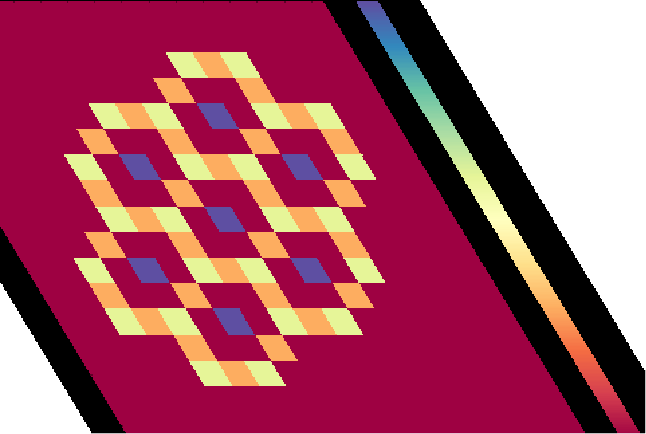

In [5]:
edge_cache = np.where(board == 0.3, 1, 0)
vert_cache = np.where(board == 0.6, 1, 0)
face_cache = np.where(board == 1.0, 1, 0)

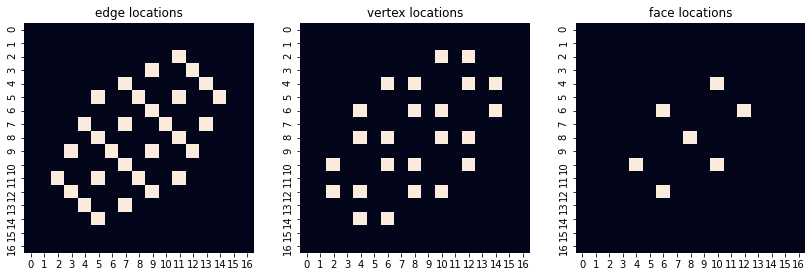

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(14,6))
axs[0].set_title('edge locations')
axs[1].set_title('vertex locations')
axs[2].set_title('face locations')

sns.heatmap(edge_cache, square=True, cbar=False, ax=axs[0])
sns.heatmap(vert_cache, square=True, cbar=False, ax=axs[1])
sns.heatmap(face_cache, square=True, cbar=False, ax=axs[2])

plt.show()

### What are your theoretical chances of getting $n$ resources in the first round?

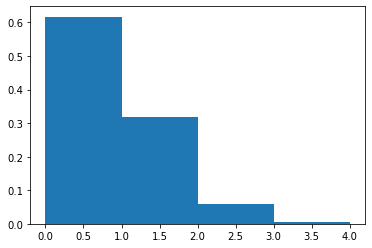

In [7]:
plt.hist([sum([sum(np.random.randint(1,7,2)) == sum(np.random.randint(1,7,2)), \
 sum(np.random.randint(1,7,2)) == sum(np.random.randint(1,7,2)), \
 sum(np.random.randint(1,7,2)) == sum(np.random.randint(1,7,2)), \
 sum(np.random.randint(1,7,2)) == sum(np.random.randint(1,7,2))]) for i in range(100000)
         ], weights = [1e-05]*100000, bins=4);

## Create game environment

### Core helper function to map correspondence between node types

These are the two types of vertices we have to deal with:

<img src="up_and_downdiag.png" width="500"/>

These are the three types of roads we have to deal with: 
<img src="roads_types2.png" width="700"/>

The below code block encodes this

In [8]:
# what roads are connected to a given house, and what roads connect to those roads?
vert2edge_down_diag = np.array([(1,0),(0,-1),(-1,1)])
vert2edge_up_diag = np.array([(0,1),(-1,0),(1,-1)])

# what are the neighboring vertices?
vert2vert_down_diag = np.array([(-2,2),(2,0),(0,-2)])
vert2vert_up_diag = np.array([(-2,0),(0,2),(2,-2)])

# what faces are connected to a given house? 
vert2face_down_diag = np.array([(-2,0), (0,2), (2,-2)])
vert2face_up_diag = np.array([(2,0), (0,-2), (-2,2)])

# what roads are connected to a given road?
edge2edge_hori = np.array([(-2,1),(-1,-1),(1,1),(2,-1)])
edge2edge_vert = np.array([(-1,-1),(-1,2),(1,-2),(1,1)])
edge2edge_diag = np.array([(-2,1),(-1,2),(1,-2),(2,-1)])

# what houses are connected to a given road?
edge2vert_hori = np.array([(-1,0),(1,0)])
edge2vert_vert = np.array([(0,-1),(0,1)])
edge2vert_diag = np.array([(-1,1),(1,-1)])

# what houses are connected to a given face?
face2vert = np.array([(0,-2),(2,-2),(2,0),(0,2),(-2,2),(-2,0)])

def transform(loc, dest_type):
    if node_board[loc].type == 'R': 
        if node_board[loc[0]+1, loc[1]-1] != None:  
            if dest_type == 'B': 
                return (edge2vert_diag + loc).tolist()
            elif dest_type == 'R':
                return (edge2edge_diag + loc).tolist()
            else: 
                raise ValueError('gris')
        elif node_board[loc[0]+1, loc[1]] == None:
            if dest_type == 'B': 
                return (edge2vert_vert + loc).tolist()
            elif dest_type == 'R':
                return (edge2edge_vert + loc).tolist()
            else: 
                raise ValueError('gris')
        else:   
            if dest_type == 'B': 
                return (edge2vert_hori + loc).tolist()
            elif dest_type == 'R':
                return (edge2edge_hori + loc).tolist()
            else:
                raise ValueError('gris') 
            
    elif node_board[loc].type[0] == 'B': # if building
        if node_board[loc[0]-1,loc[1]+1] != None or [loc[0],loc[1]] in [[2,12], [4,14]]:
            if dest_type == 'B': 
                return (vert2vert_down_diag + loc).tolist()
            elif dest_type == 'R':
                return (vert2edge_down_diag + loc).tolist()
            elif dest_type == 'T':
                return (vert2face_down_diag + loc).tolist()
            else: 
                raise ValueError('gris')
        else:
            if dest_type == 'B': 
                return (vert2vert_up_diag + loc).tolist()
            elif dest_type == 'R':
                return (vert2edge_up_diag + loc).tolist()
            elif dest_type == 'T':
                return (vert2face_up_diag + loc).tolist()
            else:
                raise ValueError('gris')
    elif node_board[loc].type[0] == 'T': # if face
        if dest_type == 'B':
            return (face2vert + loc).tolist()

### Create pseudo-random resource types
Idea: we want the resource tile values to be random, but not necessarily uniform random. I propose we draw from the same procedure used to roll the dice.

In [9]:
def generate_terrain():
    '''
    H: hill
    P: pasture
    M: mountain
    Fi: field
    Fo: forest
    '''
    terrain = ['H', 'Fo', 'H', 'Fo']
    terrain_insert = ['P', 'M', 'Fi']
    random.shuffle(terrain_insert)
    [terrain.insert(2, terrain_i) for terrain_i in terrain_insert]
    
    return terrain

def roll_die():
    return sum(np.random.randint(1,7,2))

### Populate hex board with meaningful variables
Keep the minimal information needed in the nodes

In [10]:
class Node:
    '''
    loc: the coordinate position of the hex board 
    membership: the player ownership. 0 denotes no ownership
    type: 
        - B  - building
        - BH - house
        - BC - city
        - R  - road
        - TH, TFo, TM, TFi, TP - terrain with a resource
    data: 
        - dice roll associated with terrain type structures; -1 else
    '''
    
    def __init__(self, loc, node_type, data = -1): 
        self.loc = loc
        self.membership = 0
        self.type = node_type
        self.data = data

    def __str__(self):
        return f'{self.loc}, {self.membership}, {self.type}, {self.data}'

def initialize_board():
    board = np.empty((17,17), dtype=np.object)
    
    for x, y in np.transpose(vert_cache.nonzero()):
        board[x,y] = Node((x,y), 'B') # building
    for x, y in np.transpose(edge_cache.nonzero()): 
        board[x,y] = Node((x,y), 'R') # road
    for (x,y), t in zip(np.transpose(face_cache.nonzero()), generate_terrain()):
        board[x,y] = Node((x,y), 'T' + t, data = roll_die()) # terrain

    face_access = {(x,y): board[x,y].type[1:] for x,y in np.transpose(face_cache.nonzero())}
    access_roll = {(x,y): board[x,y].data for x,y in np.transpose(face_cache.nonzero())}
    roll_access = {}
    for k, v in access_roll.items():
        roll_access[v] = roll_access.get(v, []) + [k]
    
    return board, face_access, roll_access
    
node_board, face_access, roll_access = initialize_board()

access_face = {}
for k, v in face_access.items():
    access_face[v] = access_face.get(v, []) + [k]


### Create players
Actions should go through the players

In [11]:
class Player:
    def __init__(self, player_num):
        self.num = player_num
        self.hand = {'H': 2, 'Fo': 2, 'M': 0, 'Fi': 2, 'P': 2}
        
        # locations
        self.houses = []
        self.roads = []
        
        # amount of settlement associated with each resource
        self.farms = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 0, 'P': 0}
        
        # victory points
        self.points = 0
    
    def __str__(self):
        return f'Player number {self.num}: \n{sum(self.hand.values())} cards:{self.hand} \n'+\
               f'{len(self.houses)} houses:{self.houses} \n' +\
               f'{len(self.roads)} roads: {self.roads} \n' +\
               f'{sum(self.farms.values())} farms: {self.farms} \n' +\
               f'{self.points} victory points'
        
    def add_house(self, loc, city=False): 
        if not city:
            self.houses.append(loc)
            self.hand['H']  -= 1
            self.hand['Fo'] -= 1
            self.hand['Fi'] -= 1
            self.hand['P'] -= 1
            
            node_board[loc].membership = self.num
            node_board[loc].type = 'BH'
        else:
            self.hand['Fi'] -= 2
            self.hand['M'] -= 3
            node_board[loc].type = 'BC'
                            
        for x,y in transform(loc, 'T'):
            if node_board[x,y] != None:
                self.farms[face_access[x,y]] += 1 # increment farm score by 1
        
        self.points += 1

    def add_road(self, loc):
        self.roads.append(loc)
        self.hand['H']  -= 1
        self.hand['Fo'] -= 1
        node_board[loc].membership = self.num
        
    

def initialize_game():
    
    # initialize players 
    player1 = Player(1)
    player2 = Player(2)
    
    player1.add_house((4,8))
    player2.add_house((12,8))
    
    player1.add_road((5,8))
    player2.add_road((11,8))    
    
    
    return player1, player2

player1, player2 = initialize_game()

Demonstration: players are doing what they should be doing

In [12]:
print(player1, '\n')

print(node_board[6,9])
player1.add_road((6,9))
print(node_board[6,9])
print(player1, '\n')

print(node_board[6,10])
player1.add_house((6,10))
print(node_board[6,10])
print(player1, '\n')

print(node_board[6,10])
player1.add_house((6,10), city=True)
print(node_board[6,10])
print(player1)

Player number 1: 
2 cards:{'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1} 
1 houses:[(4, 8)] 
1 roads: [(5, 8)] 
2 farms: {'H': 1, 'Fo': 1, 'M': 0, 'Fi': 0, 'P': 0} 
1 victory points 

(6, 9), 0, R, -1
(6, 9), 1, R, -1
Player number 1: 
0 cards:{'H': -1, 'Fo': -1, 'M': 0, 'Fi': 1, 'P': 1} 
1 houses:[(4, 8)] 
2 roads: [(5, 8), (6, 9)] 
2 farms: {'H': 1, 'Fo': 1, 'M': 0, 'Fi': 0, 'P': 0} 
1 victory points 

(6, 10), 0, B, -1
(6, 10), 1, BH, -1
Player number 1: 
-4 cards:{'H': -2, 'Fo': -2, 'M': 0, 'Fi': 0, 'P': 0} 
2 houses:[(4, 8), (6, 10)] 
2 roads: [(5, 8), (6, 9)] 
5 farms: {'H': 2, 'Fo': 1, 'M': 1, 'Fi': 1, 'P': 0} 
2 victory points 

(6, 10), 1, BH, -1
(6, 10), 1, BC, -1
Player number 1: 
-9 cards:{'H': -2, 'Fo': -2, 'M': -3, 'Fi': -2, 'P': 0} 
2 houses:[(4, 8), (6, 10)] 
2 roads: [(5, 8), (6, 9)] 
8 farms: {'H': 3, 'Fo': 1, 'M': 2, 'Fi': 2, 'P': 0} 
3 victory points


## Define game logic 

### Find what moves are avaliable to the player

In [13]:
# make sure that this house's location isn't neighboring anyone
def assert_surrounding_verts(x,y):
    for vert in transform((x,y), 'B'): # for each neighbor
        if node_board[tuple(vert)] != None and node_board[tuple(vert)].membership != 0: 
            return False # if one of them is owned, then we can't build here
    return True 


def check_avaliable_vert(player):
    # branch out from the roads we own, adding to our list if we also own that branch
    branches = [tuple(branch) for road in player.roads for branch in transform(road, 'R') \
                                       if tuple(branch) in player.roads]
    # drop repeats
    branches = list(set(branches))
    
    # from the eligible roads, get the eligible houses 
    houses = [tuple(a) for branch in branches for a in transform(tuple(branch), 'B') \
                                  if assert_surrounding_verts(a[0],a[1]) and node_board[a[0],a[1]].membership == 0]

    return list(set(houses))
    
    
def check_avaliable_edge(player):
    # get all potential edges  
    nodes = [tuple(branch) for road in player.roads for branch in transform(road, 'R')]
    nodes = list(set(nodes))
    
    # check all potential edges for elegibility
    nodes = [node for node in nodes if node_board[node] != None and node_board[node].membership == 0]
    return nodes


# later on: the state-action loop that the agent can take is a while loop
def generate_possible_actions(board, player):
    '''
    Look at player's resources to see what high-level actions can be done
    Helper function for environment_to_state()
    
    If the player has enough resource, call check_avaliable_vert() and/or check_avaliable_edge() to generate 
    location options. 
    Return possible actions to the player in the form: (first two actually will go into the state)
        - can a road be built
        - can a building be built
        - of the buildings that can be built, what resource do they provide (?)
        - of the roads that can be built, (possibly) what resource do they build towards
        - etc? maybe not all of these either
    
    actions: of the form (bool, bool, ...)
        
    '''
    # what do we have the resources to build?
    build_road = all([i > 0 for i in map(player.hand.get, ['H', 'Fo'])])
    build_house = all([i > 0 for i in map(player.hand.get, ['H', 'Fo', 'Fi', 'P'])])
    build_city = player.hand['P'] > 1 and player.hand['M'] > 2
    
    # if we have the resources, what can we get from building?
    if build_house:
        nodes_house = check_avaliable_vert(player)
        build_house = len(nodes) != 0 
        for node in nodes_house:
            pass

    if build_road:
        nodes_road = check_avaliable_edge(player)
    if build_city:
        pass
        
    
    return actions

In [248]:
print(check_avaliable_vert(player1))
print(check_avaliable_edge(player1))
print([node_board[edge].membership for edge in check_avaliable_edge(player1)])
print([node_board[vert].membership for vert in check_avaliable_vert(player1)])

[(6, 14), (6, 4), (12, 2), (8, 12), (10, 6), (6, 10), (4, 14), (8, 10), (10, 2), (10, 12), (12, 4), (4, 12), (2, 12), (8, 6), (8, 4)]
[(6, 9), (4, 7), (11, 11), (11, 2), (13, 4)]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# check for efficiency
t = time.time()
for i in range(1000000):
    check_avaliable_vert(player1)
print(time.time() - t)

t = time.time()
for i in range(1000000):
    check_avaliable_edge(player1)
print(time.time() - t)

### Encode the state and action space for the RL agent

In [33]:
action_resource = {1: 'H', 2: 'Fo', 3: 'M', 4: 'Fi', 5: 'P'}

def environment_to_state(player):
    '''
    State space: (8,8) x (2,2,2,2,2) x (4,4) x (2,2,2)
    (8,8):
    Index 0: # of player roads (1 to 9)
    Index 1: # of opponent roads (1 to 9)
    
    (2,2,2,2,2)
    Index 2: # player farm > opponent farm (Hill)
    Index 3: # player farm > opponent farm (Forest)
    Index 4: # player farm > opponent farm (Mountain)
    Index 5: # player farm > opponent farm (Field)
    Index 6: # player farm > opponent farm (Pasture)
    
    (4,4)
    Index 7: # of player victory points (1-4)
    Index 8: # of opponent victory points (1-4)
    
    (2,2,2) (subject to change)
    Index 9: can build road?
    Index 10: can build house?
    Index 11: can build city? 
    
    '''
    state  = [] 
    state.append(len(player1.roads))
    state.append(len(player2.roads))
    
    state += [int(x > y) for x,y in zip(player1.farms.values(), player2.farms.values())]
    
    state.append(player1.points)
    state.append(player2.points)
    
    state.append(int(all([i > 0 for i in map(player.hand.get, ['H', 'Fo'])])))
    state.append(int(all([i > 0 for i in map(player.hand.get, ['H', 'Fo', 'Fi', 'P'])])))
    state.append(int(player.hand['Fi'] > 1 and player.hand['M'] > 2))
        
    return state


def optimize_selection(choices, goals):
    min_dist = 1000
    best_loc = None
    for choice in choices:
            for goal in goals:
                if np.linalg.norm(np.array(goal) - np.array(choice)) < min_dist:
                    best_loc = choice
    return best_loc


def get_best_loc(action, player):
    targets = access_face[action_resource[action[1]]]
    
    if action[0] == 1:
        candidates = check_avaliable_edge(player)
        best_loc = optimize_selection(candidates, targets)
    elif action[0] == 2:
        candidates = check_avaliable_vert(player)
        best_loc = optimize_selection(candidates, targets)
    elif action[0] == 3:
        candidates = list(set([house for house in player.houses for target in targets \
                                                if list(target) in transform(house, 'T')]))
        best_loc = random.choice(candidates)
    
    return best_loc
    
    
def roll_for_turn():
    roll = roll_die()
    if roll in roll_access.keys(): # if the roll corresponds to a face (can be more than one)
        for loc in roll_access[roll]: # for each corresponding face location 
            for vert in transform(loc, 'B'): # for each house location corresponding to the face
                if node_board[tuple(vert)].membership == player1.num: # if player 1 owns the face
                    if node_board[tuple(vert)].type[1] == 'H': # and it's a house
                        player1.hand[face_access[loc]] += 1 # get a resource!
                    else:                                   # otherwise it's a city
                        player1.hand[face_access[loc]] += 2 # and get 2 resource!

                elif node_board[tuple(vert)].membership == player2.num: # if player 2 owns the face
                    if node_board[tuple(vert)].type[1] == 'H': # and it's a house
                        player2.hand[face_access[loc]] += 1 # get a resource!
                    else:                                   # otherwise it's a city
                        player2.hand[face_access[loc]] += 2 # and get 2 resource!
                        
    
def step(state, action, player):
    '''
    step is the agent's interaction with the environment. The following must happen:
        - take in the agent's (simplified) action representation
        - translate that action into a change in the environment
        - translate the change in the environment into a new state
        - return the state and reward to the agent
    
    "translate that action into a change in the environment": 
        - we need to do some offline computation to decide for the agent which road/building space to build on
        - we also need to do the offline computation to update the resource environment
    
    action: 
    (0,0): do nothing
    (1,:): build a road
    (2,:): build a house
    (3,:): build a city
    (:,1): Target hill  
    (:,2): Target forest
    (:,3): Target mountain
    (:,4): Target field
    (:,5): Target pasture
    '''
        
    if action != (0,0):
        targets = access_face[action_resource[action[1]]]

        if action[0] == 1:
            candidates = check_avaliable_edge(player)
            best_loc = optimize_selection(candidates, targets)
            player.add_road(best_loc)
            
        elif action[0] == 2:
            candidates = check_avaliable_vert(player)
            best_loc = optimize_selection(candidates, targets)
            player.add_house(best_loc)
        elif action[0] == 3:
            candidates = list(set([house for house in player.houses for target in targets \
                                                    if list(target) in transform(house, 'T')]))
            best_loc = random.choice(candidates)
            player.add_house(best_loc, city=True)

    reward = 1 if player.points == 4 else 0
        
    new_state = environment_to_state(player)
    
    return new_state, reward
    

In [34]:
print(player1.hand)
print(player2.hand)

{'H': 1, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
{'H': 0, 'Fo': 1, 'M': 0, 'Fi': 1, 'P': 1}


In [38]:
roll_for_turn()
print(environment_to_state(player1), player1.hand)
print(environment_to_state(player2), player2.hand)

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0] {'H': 3, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0] {'H': 1, 'Fo': 3, 'M': 0, 'Fi': 1, 'P': 1}


[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0] {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0] {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}


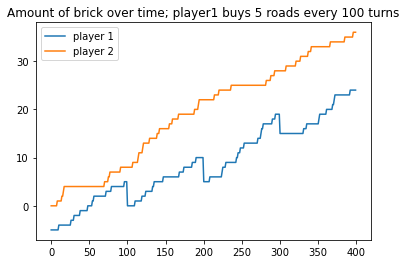

In [247]:
node_board, face_access, roll_access = initialize_board()
player1, player2 = initialize_game()
access_face = {}
for k, v in face_access.items():
    access_face[v] = access_face.get(v, []) + [k]
print(environment_to_state(player1), player1.hand)
print(environment_to_state(player2), player2.hand)

p1 = []
p2 = []
for i in range(400):
    roll_for_turn()
    if i % 100 == 0:
        state_p1 = environment_to_state(player1)
        action1 = (1,3) # I want to build a road in the direction of a forest
        new_state, reward = step(state_p1, action1, player1)
        new_state, reward = step(state_p1, action1, player1)
        new_state, reward = step(state_p1, action1, player1)
        new_state, reward = step(state_p1, action1, player1)
        new_state, reward = step(state_p1, action1, player1)


    p1.append(player1.hand['H'])
    p2.append(player2.hand['H'])

plt.plot(p1, label='player 1')
plt.plot(p2, label='player 2');
plt.title('Amount of brick over time; player1 buys 5 roads every 100 turns')
plt.legend()

[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0] {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0] {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}


In [134]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


In [162]:
def create_board():
    board2 = board.copy()
    for x in range(17):
        for y in range(17):
            if node_board[x,y] != None:
                if node_board[x,y].type == 'BH':
                    board2[y,x] = node_board[x,y].membership + 5
                elif node_board[x,y].type[0] == 'T':
                    board2[y,x] = ord(node_board[x,y].type[-1]) / 25
                elif node_board[x,y].type == 'R' and node_board[x,y].membership != 0:
                    board2[y,x] = node_board[x,y].membership + 3.5
                else: 
                    board2[y,x] = node_board[x,y].membership 
            else:
                board2[y,x] = 0
    return board2

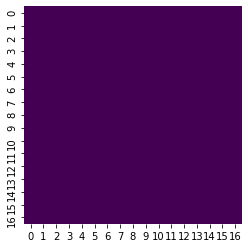

In [166]:
fig = plt.figure()
node_board, face_access, roll_access = initialize_board()
player1, player2 = initialize_game()
access_face = {}
for k, v in face_access.items():
    access_face[v] = access_face.get(v, []) + [k]
board2 = create_board()
sns.heatmap(board2, square=True, cmap='viridis', cbar=False)

def init():     
    sns.heatmap(np.zeros((17,17)), square=True, cmap='viridis', cbar=False)
    
def funanim(i):
    if i <= 3:
        state_p1 = environment_to_state(player1)
        action1 = (1,3) # I want to build a road in the direction of a forest
        new_state, reward = step(state_p1, action1, player1)
    elif i == 4:
        state_p1 = environment_to_state(player1)
        action1 = (2,3) # I want to build a road in the direction of a forest
        new_state, reward = step(state_p1, action1, player1)
    elif i <= 6:
        state_p1 = environment_to_state(player1)
        action1 = (1,5) # I want to build a road in the direction of a forest
        new_state, reward = step(state_p1, action1, player1)
    elif i == 7:
        state_p1 = environment_to_state(player1)
        action1 = (2,5) # I want to build a road in the direction of a forest
        new_state, reward = step(state_p1, action1, player1)


    board2 = create_board()
    ax = sns.heatmap(board2, square=True, cmap='viridis', cbar=False)

anim = animation.FuncAnimation(fig, funanim, init_func=init, frames=8, repeat = False, interval = 1000)
HTML(anim.to_html5_video())


In [249]:
state_p1 = environment_to_state(player1)
action1 = (1,5) # I want to build a road in the direction of a Pasture
new_state, reward = step(state_p1, action1, player1)
print(state_p1)
print(new_state)

[21, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
[22, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]


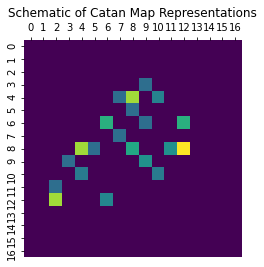

In [167]:
state_p1 = environment_to_state(player1)
action1 = (1,5) # I want to build a road in the direction of a forest
new_state, reward = step(state_p1, action1, player1)

state_p2 = environment_to_state(player2)
action2 = (1,4) # I want to build a road in the direction of a forest
new_state, reward = step(state_p2, action2, player2)


board2 = board.copy()
for x in range(17):
    for y in range(17):
        if node_board[x,y] != None:
            if node_board[x,y].type == 'BH':
                board2[y,x] = node_board[x,y].membership + 5
            elif node_board[x,y].type[0] == 'T':
                board2[y,x] = ord(node_board[x,y].type[-1]) / 25
            elif node_board[x,y].type == 'R' and node_board[x,y].membership != 0:
                board2[y,x] = node_board[x,y].membership + 1.5
            else: 
                board2[y,x] = node_board[x,y].membership 

        else:
            board2[y,x] = 0

plt.figure(figsize=(6,4))
ax = sns.heatmap(board2, square=True, cmap='viridis', cbar=False)
ax.xaxis.tick_top() # x axis on top
plt.title('Schematic of Catan Map Representations');
plt.show()

In [88]:
state_p1 = environment_to_state(player1)
print(state_p1, player1.hand)
action = (1,5) # I want to build a road in the direction of a forest
new_state, reward = step(state_p1, action, player1)
print(new_state, player1.hand)

[4, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0] {'H': -3, 'Fo': -3, 'M': 0, 'Fi': 1, 'P': 1}
[4, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0] {'H': -4, 'Fo': -4, 'M': 0, 'Fi': 0, 'P': 0}


### Old code

In [ ]:
  
# make sure that this house's location isn't neighboring anyone
def assert_surrounding_verts(x,y):   # for a candidate house location
    if node_board[x-1,y+1] != None or [x,y] in [[2,12], [4,14]]: # if it's a "down-diagonal" vertex 
        potential_verts = [[-2,2],[2,0],[0,-2]] # then these are the possible neighbors
        for vert in potential_verts: # for each possible neighbor
            # check that it isn't out of bounds and that it isn't already owned
            if node_board[x+vert[0],y+vert[1]] != None \
            and node_board[x+vert[0],y+vert[1]].membership != 0:
                return False   # otherwise it fails the check
    else:  # otherwise if it's an "up-diagonal" vertex
        potential_verts = [[-2,0],[0,2],[2,-2]] # then these are the possible neighbors
        for vert in potential_verts:   # for each possible neighbor
            # check that it isn't out of bounds and that it isn't already owned
            if node_board[x+vert[0],y+vert[1]] != None and \
               node_board[x+vert[0],y+vert[1]].membership != 0:  
                return False  # otherwise it fails the check
    return True
    
vert_cache_cache = np.transpose(vert_cache.nonzero())
def check_avaliable_vert(player):
    
    nodes = []
    for x,y in vert_cache_cache: # for every possible house location
        if node_board[x,y].membership == 0:      # if it isn't already owned
            if assert_surrounding_verts(x,y):      # and if this location isn't neighboring anyone else
                # check for the roads now:
                if node_board[x-1,y+1] != None or [x,y] in [[2,12], [4,14]]: # if it's "down-diagonal"
                    for key, value in vert2edge_down_diag.items(): # then, checking for each nearby road
                        # if you occupy the road
                        if node_board[x+key[0],y+key[1]] != None and node_board[x+key[0],y+key[1]].membership == player.num:
                            # and you also occupy one of the road's neighbors 
                            check1 = node_board[x+value[0][0],y+value[0][1]]
                            check2 = node_board[x+value[1][0],y+value[1][1]]
                            if check1 != None and check1.membership == player.num or\
                               check2 != None and check2 == player.num:
                                # add the house location to the possible house locations
                                nodes.append(node_board[x,y]) 
                else: # otherwise if it's "up-diagonal"
                    for key, value in vert2edge_up_diag.items(): # then, checking for each nearby road
                        # if you occupy the road
                        if node_board[x+key[0],y+key[1]] != None and node_board[x+key[0],y+key[1]].membership == player.num:
                            # and you also occupy one of the road's neighbors 
                            check1 = node_board[x+value[0][0],y+value[0][1]]
                            check2 = node_board[x+value[1][0],y+value[1][1]]
                            if check1 != None and check1.membership == player.num or\
                               check2 != None and check2.membership == player.num:
                                nodes.append(node_board[x,y]) # add the house location to the possible house locations
    return nodes

edge_cache_cache = np.transpose(edge_cache.nonzero())

def check_avaliable_edge(player):
    nodes = []
    for x,y in edge_cache_cache:
        if node_board[x,y].membership == player.num:            
            if node_board[x+1, y-1] != None:
                potential_edges = [[2,-1],[1,-2],[-2,1],[-1,2]]
                for edge in potential_edges:
                    if node_board[x+edge[0],y+edge[1]] != None and node_board[x+edge[0],y+edge[1]].membership == 0:
                        nodes.append(node_board[x+edge[0],y+edge[1]])
            elif node_board[x+1, y] == None:
                potential_edges = [[1,1],[-1,-1],[1,2],[-1,-2]]
                for edge in potential_edges:
                    if node_board[x+edge[0],y+edge[1]] != None and node_board[x+edge[0],y+edge[1]].membership == 0:
                        nodes.append(node_board[x+edge[0],y+edge[1]])
            else:
                potential_edges = [[1,1],[-1,-1],[2,-1],[-2,1]]
                for edge in potential_edges:
                    if node_board[x+edge[0],y+edge[1]] != None and node_board[x+edge[0],y+edge[1]].membership == 0:
                        nodes.append(node_board[x+edge[0],y+edge[1]])
    return nodes

In [ ]:
class Resource:
    hand1 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
    hand2 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}

    def reset():
        hand1 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}
        hand2 = {'H': 0, 'Fo': 0, 'M': 0, 'Fi': 1, 'P': 1}


In [ ]:
[np.linalg.norm(road - np.transpose(face_cache.nonzero()), axis=1) for road in player1.roads]
# want to somehow vectorize
#np.linalg.norm(player1.owned_road - np.transpose(face_cache.nonzero()), axis=1, keepdims = True)